<a href="https://colab.research.google.com/github/JeanAlmeida1/Previsao-atraso-entregas/blob/main/Hackathon_UELLO_previs%C3%A3o_de_entregas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUPER CHALLENGE - DNC, powered by UELLO

**DESAFIO:** Em prol de melhorar a experiência e fidelizar seus clientes a UELLO
coletou em sua base de dados os pedidos já entregues e solicitou ao time de
ciências de dados para construir um modelo que os auxiliem em entender os
atrasos e criar uma hipótese para evitá-los no futuro. 

**ESTRATÉGIA:** Criar uma variável target binária que diz se a entrega atrasou ou não, e utilizar um algoritmo de classificação para prever esses atrasos. Como não se tem muitas variáveis, é de suma importância criar novas features para enriquecer o modelo. Entre elas, utilizar um algoritmo de clusterização para agrupar cidades com características semelhantes pode ser útil.




## Instalação e importação de pacotes 

In [ ]:
!pip install scikit-learn-extra -q
!pip install fuzzy-c-means -q

In [ ]:
# Importando bibliotecas iniciais
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
import re
%matplotlib inline

# Importando algortmos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Importando algoritmos de clusterização
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from fcmeans import FCM

# Importando ferramentas para dividir os dados
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Importando métricas
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Importando outros pacotes
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
import time
import datetime 
from datetime import timedelta
from matplotlib import pylab
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

## Inspeção inicial

In [ ]:
df = pd.read_csv("ordens_case_dnc_.csv")

In [ ]:
display(df.head(3))
print("shape: ", df.shape)

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
0,0,107.78,2022-02-25 20:46:25+00:00,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,1,7.47,2022-02-23 20:34:59+00:00,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0
2,2,5.98,2022-02-23 20:35:19+00:00,2022-02-24 00:00:00,2022-02-23 20:29:38,2022-02-24 22:55:38,2,1,88,1,202.0


shape:  (1795, 11)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1795 non-null   int64  
 1   price              1795 non-null   float64
 2   order_date         1795 non-null   object 
 3   due_date           1795 non-null   object 
 4   opt_date           1795 non-null   object 
 5   delivery_date      1795 non-null   object 
 6   cidade_origem_id   1795 non-null   int64  
 7   regiao_origem_id   1795 non-null   int64  
 8   cidade_destino_id  1795 non-null   int64  
 9   regiao_destino_id  1795 non-null   int64  
 10  peso               1795 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 154.4+ KB


A base de dados não possui dados nulos; algumas datas estão sendo consideradas como tipo objeto. 

In [ ]:
print("Quantidade de cidades origem: ", df['cidade_origem_id'].nunique())
print("Quantidade de cidades destino: ", df['cidade_destino_id'].nunique())
print("Quantidade de região origem: ", df['regiao_origem_id'].nunique())
print("Quantidade de região destino: ", df['regiao_destino_id'].nunique())

Quantidade de cidades origem:  5
Quantidade de cidades destino:  124
Quantidade de região origem:  3
Quantidade de região destino:  3


In [ ]:
print("regiões de origem: ", df['regiao_origem_id'].unique())
print("regiões de destino: ", df['regiao_destino_id'].unique())

regiões de origem:  [1 2 3]
regiões de destino:  [1 4 2]


In [ ]:
# quão normal é a região de origem ser diferente da região de destino?

(df['regiao_origem_id'] != df['regiao_destino_id']).value_counts()

True     1231
False     564
dtype: int64

A região é igual à região de destino somente 564 vezes, isto é, em cerca de 31,4% das entregas

## Transformação dos dados

In [ ]:
# Transformando order_date de forma que fique igual as outras datas 
df['order_date'] = df['order_date'].str.replace(r'\+00:00$','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Para criar a variável target de atraso, é necessário alterar "due_date", pois todos os seus horários são 00:00:00, diferentemente de "delivery date". Dessa forma, uma entrega agendada para dia 23/02 e que foi entregue dia 23/02 às 15:54 seria considerada atraso, o que não seria verdade. Um passo simples para evitar esse problema é simplesmente alterar os horários de "due_date" para 23:59:59.  

In [ ]:
# Alterando os horários de "due_date" para 23:59:59. 
df['due_date'] = df['due_date'].str.replace(r'\d\d:\d\d:\d\d$','23:59:59')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
df.head()

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
0,0,107.78,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,1,7.47,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0
2,2,5.98,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,1,88,1,202.0
3,3,5.98,2022-02-10 14:34:37,2022-02-17 23:59:59,2022-02-17 07:47:49,2022-02-17 14:23:12,2,1,21,1,441.0
4,4,5.98,2022-02-23 20:35:05,2022-02-24 23:59:59,2022-02-23 20:28:40,2022-02-24 12:08:00,2,1,25,1,316.0


In [ ]:
# Transformando as colunas de datas para o formato datetime
datas = ['order_date', 'due_date', 'opt_date', 'delivery_date']
for col in datas: 
  df[col] = pd.to_datetime(df[col])

In [ ]:
df.dtypes

id                            int64
price                       float64
order_date           datetime64[ns]
due_date             datetime64[ns]
opt_date             datetime64[ns]
delivery_date        datetime64[ns]
cidade_origem_id              int64
regiao_origem_id              int64
cidade_destino_id             int64
regiao_destino_id             int64
peso                        float64
dtype: object

In [ ]:
# Criando coluna tempo de entrega 
df['delivery_time'] = df['delivery_date'] - df['order_date']
df['delivery_time'].head()

0   4 days 21:17:08
1   0 days 19:17:41
2   1 days 02:20:19
3   6 days 23:48:35
4   0 days 15:32:55
Name: delivery_time, dtype: timedelta64[ns]

In [ ]:
df.sort_values(by='delivery_time', ascending=True)

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,delivery_time
1222,1222,5.98,2022-02-17 20:21:09,2022-02-21 23:59:59,2022-02-17 21:02:06,2022-02-18 08:07:24,4,2,3,1,0.43,0 days 11:46:15
451,451,5.49,2022-02-15 20:36:09,2022-02-17 23:59:59,2022-02-15 20:56:10,2022-02-16 08:50:41,4,2,20,1,285.00,0 days 12:14:32
607,607,5.98,2022-02-23 20:17:22,2022-02-25 23:59:59,2022-02-23 21:16:25,2022-02-24 08:32:46,4,2,29,1,458.00,0 days 12:15:24
678,678,7.04,2022-02-15 20:36:07,2022-02-17 23:59:59,2022-02-15 20:29:00,2022-02-16 09:10:47,4,2,45,1,398.00,0 days 12:34:40
620,620,7.15,2022-02-23 20:17:00,2022-02-25 23:59:59,2022-02-23 21:15:00,2022-02-24 08:55:02,4,2,29,1,819.00,0 days 12:38:02
...,...,...,...,...,...,...,...,...,...,...,...,...
1364,1364,7.34,2022-02-18 12:44:05,2022-02-21 23:59:59,2022-02-23 22:07:31,2022-03-09 16:15:06,2,1,59,1,0.00,19 days 03:31:01
72,72,6.75,2022-02-18 17:06:40,2022-03-04 23:59:59,2022-02-21 21:08:29,2022-03-10 13:50:46,1,1,6,1,0.50,19 days 20:44:06
1548,1548,7.42,2022-02-18 11:14:22,2022-03-01 23:59:59,2022-03-03 10:21:19,2022-03-10 08:29:17,5,3,108,2,0.18,19 days 21:14:55
9,9,7.42,2022-02-11 13:15:49,2022-02-24 23:59:59,2022-02-19 08:26:43,2022-03-04 20:08:34,2,1,93,2,525.00,21 days 06:52:45


In [ ]:
# Criando função que retorna 1 caso a entrega atrasou; 0 se foi entregue dentro do prazo estipulado (será a variável target)

def delay_time(dfcol_data_prevista, dfcol_data_realizada):
  delay = []
  delay = np.where(dfcol_data_realizada > dfcol_data_prevista, 1, 0)
  return delay

In [ ]:
delay_dummy = delay_time(df['due_date'], df['delivery_date'])

In [ ]:
df['delay'] = delay_dummy

In [ ]:
df.head(3)

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,delivery_time,delay
0,0,107.78,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8,4 days 21:17:08,0
1,1,7.47,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0,0 days 19:17:41,0
2,2,5.98,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,1,88,1,202.0,1 days 02:20:19,0


In [ ]:
df['delay'].value_counts(normalize=True)

0    0.856825
1    0.143175
Name: delay, dtype: float64

Text(0.5, 0, 'Entregas por tipo')

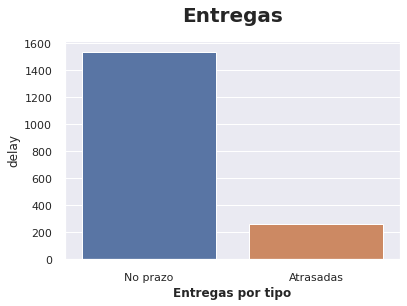

In [ ]:
# Entregas atrasadas e no prazo 
fig = sns.barplot(x=df['delay'].unique(), y=df['delay'].value_counts())
plt.title('Entregas', fontweight='bold', fontsize=20, pad=20)
fig.set_xticklabels(['No prazo','Atrasadas']); 
plt.xlabel('Entregas por tipo', fontweight='bold')

Cerca de 14,3% das entregas atrasaram.

In [ ]:
# Atrasos por região de destino
for regiao in df['regiao_destino_id'].unique():
  print('Região', regiao)
  print('Quantidade de Entregas: ', df[df['regiao_destino_id']==regiao].shape[0])
  print('Porcentagem de atrasos: {0:.3f}%'.format(df[df['regiao_destino_id']==regiao]['delay'].value_counts(normalize=True)[1]))
  print()

Região 1
Quantidade de Entregas:  1698
Porcentagem de atrasos: 0.127%

Região 4
Quantidade de Entregas:  66
Porcentagem de atrasos: 0.424%

Região 2
Quantidade de Entregas:  31
Porcentagem de atrasos: 0.419%



In [ ]:
# Atrasos por região de origem
for regiao in df['regiao_origem_id'].unique():
  print('Região de origem', regiao)
  print('Quantidade de Entregas que saíram dessa região: ', df[df['regiao_origem_id']==regiao].shape[0])
  print('Porcentagem de atrasos de entregas que saíram dessa região: {0:.3f}%'.format(df[df['regiao_origem_id']==regiao]['delay'].value_counts(normalize=True)[1]))
  print()

Região de origem 1
Quantidade de Entregas que saíram dessa região:  638
Porcentagem de atrasos de entregas que saíram dessa região: 0.197%

Região de origem 2
Quantidade de Entregas que saíram dessa região:  896
Porcentagem de atrasos de entregas que saíram dessa região: 0.066%

Região de origem 3
Quantidade de Entregas que saíram dessa região:  261
Porcentagem de atrasos de entregas que saíram dessa região: 0.276%



In [ ]:
# Quantidade de entregas por cidade de destino
cidade_delivery = pd.DataFrame(df['cidade_destino_id'].value_counts())
cidade_delivery.rename(columns={'cidade_destino_id':'qtd_delivery_cidade'}, inplace=True)
cidade_delivery.index.rename('cidade_destino_id', inplace=True)
cidade_delivery.reset_index(inplace=True)
cidade_delivery

,cidade_destino_id,qtd_delivery_cidade
0,2,589
1,25,85
2,16,60
3,24,59
4,18,46
...,...,...
119,82,1
120,105,1
121,121,1
122,116,1


In [ ]:
# 10 cidades com mais porcentagem de atrasos 
cidade_delay = df.groupby('cidade_destino_id', as_index=False).agg({'delay':'mean'})
cidade_delay.sort_values(by='delay', ascending=False)

,cidade_destino_id,delay
92,95,1.0
113,116,1.0
64,67,1.0
69,72,1.0
57,60,1.0
...,...,...
79,82,0.0
81,84,0.0
82,85,0.0
85,88,0.0


Temos cidades que todas as entregas nelas atrasaram, provavelmente por termos poucas entregas nelas. 

In [ ]:
# Adicionando a quantidade de entregas no dataframe acima
destinos = cidade_delay.merge(right=cidade_delivery)
destinos.sort_values(by='qtd_delivery_cidade', ascending=False)

,cidade_destino_id,delay,qtd_delivery_cidade
1,2,0.047538,589
22,25,0.070588,85
13,16,0.416667,60
21,24,0.406780,59
15,18,0.021739,46
...,...,...,...
64,67,1.000000,1
102,105,1.000000,1
101,104,0.000000,1
78,81,0.000000,1


In [ ]:
print('Quantidade de destinos que todas as entregas chegaram com atraso: ', destinos[destinos['delay']==1].shape[0])

Quantidade de destinos que todas as entregas chegaram com atraso:  20


In [ ]:
# Mostrando, entre as cidades que chegaram a ter entregas no tempo certo, as com maior porcentagem de entregas atrasadas
destinos.sort_values(by='delay', ascending=False).iloc[20:30]

,cidade_destino_id,delay,qtd_delivery_cidade
31,34,0.888889,9
105,108,0.857143,7
56,59,0.750000,4
20,23,0.750000,8
74,77,0.666667,3
7,10,0.636364,11
45,48,0.625000,8
60,63,0.571429,7
9,12,0.545455,11
54,57,0.500000,4


### Variável dummy de dia não-útil 

**Variável final de semana:** O dia da semana é muito importante em uma base de dados de entregas. Dessa forma, é interessante criar uma variável final_semana que retorna 0 se o dia é considerado útil, e 1 caso contrário.    

In [ ]:
df_util = df.copy()

In [ ]:
indices = list(df_util.index)
df_util['week_day'] = df_util['delivery_date']
for n in indices:
  df_util['week_day'].loc[n] = df_util['delivery_date'].loc[n].weekday()
df_util['final_semana'] = df_util['week_day'].apply(lambda x : 1 if(x >4) else 0 )
#df_util = df_util.drop(columns = ['week_day']) 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df_util

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,delivery_time,delay,week_day,final_semana
0,0,107.78,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.80,4 days 21:17:08,0,2,0
1,1,7.47,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.00,0 days 19:17:41,0,3,0
2,2,5.98,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,1,88,1,202.00,1 days 02:20:19,0,3,0
3,3,5.98,2022-02-10 14:34:37,2022-02-17 23:59:59,2022-02-17 07:47:49,2022-02-17 14:23:12,2,1,21,1,441.00,6 days 23:48:35,0,3,0
4,4,5.98,2022-02-23 20:35:05,2022-02-24 23:59:59,2022-02-23 20:28:40,2022-02-24 12:08:00,2,1,25,1,316.00,0 days 15:32:55,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,1790,8.29,2022-02-18 22:55:19,2022-02-22 23:59:59,2022-02-21 21:11:11,2022-02-22 10:05:08,2,1,2,1,3.05,3 days 11:09:49,0,1,0
1791,1791,12.73,2022-02-16 17:30:56,2022-02-17 23:59:59,2022-02-16 21:08:23,2022-02-17 14:43:02,2,1,2,1,5.50,0 days 21:12:06,0,3,0
1792,1792,9.70,2022-02-18 16:01:10,2022-02-22 23:59:59,2022-02-18 20:52:11,2022-02-22 11:31:38,2,1,2,1,1683.00,3 days 19:30:28,0,1,0
1793,1793,6.75,2022-02-27 15:56:42,2022-03-02 23:59:59,2022-03-02 09:51:20,2022-03-02 14:37:17,2,1,19,1,697.00,2 days 22:40:35,0,2,0


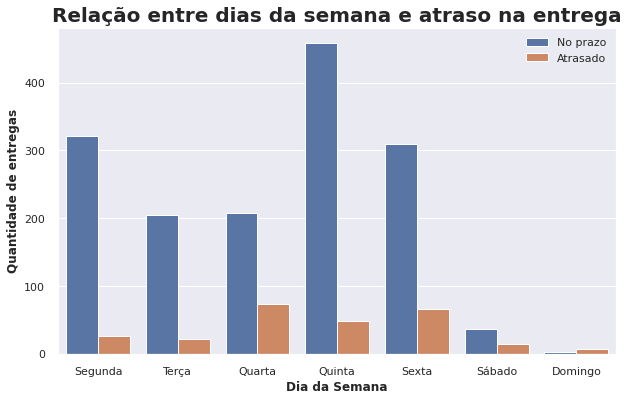

In [ ]:
# Relação entre atrasos e dia da semana 

plt.figure(figsize=(10,6))
ax = sns.countplot(x='week_day', hue='delay', data=df_util)
plt.title('Relação entre dias da semana e atraso na entrega', fontweight='bold', fontsize=20)
plt.xlabel('Dia da Semana', fontweight='bold')
plt.ylabel('Quantidade de entregas', fontweight='bold')
plt.legend(labels=["No prazo","Atrasado"])
legenda = ('Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo')
plt.xticks(np.arange(len(legenda)), legenda)
plt.show() 

Quarta e Sexta são os dias com mais atrasos em termos absolutos. Para uma análise mais precisa, é interessante observar os atrasos em termos percentuais. 

In [ ]:
# Atrasos percentual 
df_util2 = df_util 
df_util2['week_day'] = df_util2['week_day'].replace({0:'Segunda', 1:'Terça', 2:'Quarta', 3:'Quinta', 4:'Sexta', 5:'Sábado', 6:'Domingo'})
df_atrasos = df_util2[df_util2['delay']==1]
df_sematrasos = df_util2[df_util2['delay']==0]

dfa1 = pd.DataFrame(df_atrasos['week_day'].value_counts())
dfa1

,week_day
Quarta,73
Sexta,66
Quinta,48
Segunda,26
Terça,22
Sábado,15
Domingo,7


In [ ]:
# Quantidade de entregas por dia 
dfa2 = pd.DataFrame(df_util2['week_day'].value_counts())
dfa2 

,week_day
Quinta,506
Sexta,376
Segunda,347
Quarta,280
Terça,226
Sábado,51
Domingo,9


In [ ]:
dfa3 = pd.merge(right=dfa1, left=dfa2, left_index=True, right_index=True)
dfa3 = dfa3.rename(columns={'week_day_x': 'Quantidade de entregas', 'week_day_y' : 'Atrasos'})
dfa3['Percentual de atrasos'] = (dfa3['Atrasos']/dfa3['Quantidade de entregas'])
dfa3

,Quantidade de entregas,Atrasos,Percentual de atrasos
Quinta,506,48,0.094862
Sexta,376,66,0.175532
Segunda,347,26,0.074928
Quarta,280,73,0.260714
Terça,226,22,0.097345
Sábado,51,15,0.294118
Domingo,9,7,0.777778


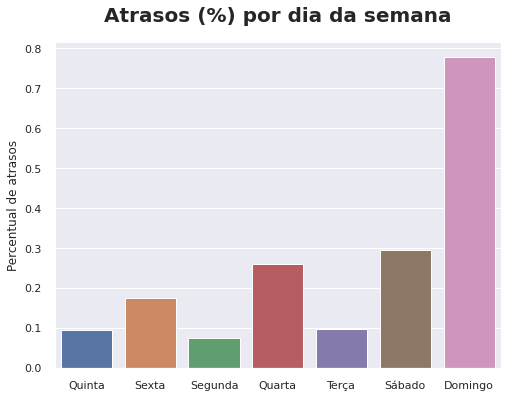

In [ ]:
# Atrasos percentuais por dia da semana
plt.figure(figsize=(8,6))
plt.title('Atrasos (%) por dia da semana', fontweight='bold', fontsize=20, pad=20)
sns.barplot(data=dfa3, x=dfa3.index, y='Percentual de atrasos');

Percebe-se que os finais de semana são as datas com mais atrasos em termos percentuais.

In [ ]:
df_util = df_util.drop(['week_day'],axis=1)
df = df_util.copy()

In [ ]:
df['final_semana'].value_counts()

0    1735
1      60
Name: final_semana, dtype: int64

### Criando variável de complexidade do pedido

**Variável complexidade:** a ideia aqui é que a diferença entre o prazo estipulado para entrega e a data que o pedido foi feito nos mostre uma medida do quão complexo é o preparo do pedido. Isso pode ser uma variável que vai impactar na logística. 

In [ ]:
df['complexidade'] = (df['due_date'] - df['order_date'])

In [ ]:
df.head()

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,delivery_time,delay,final_semana,complexidade
0,0,107.78,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8,4 days 21:17:08,0,0,5 days 03:13:34
1,1,7.47,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0,0 days 19:17:41,0,0,1 days 03:25:00
2,2,5.98,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,1,88,1,202.0,1 days 02:20:19,0,0,1 days 03:24:40
3,3,5.98,2022-02-10 14:34:37,2022-02-17 23:59:59,2022-02-17 07:47:49,2022-02-17 14:23:12,2,1,21,1,441.0,6 days 23:48:35,0,0,7 days 09:25:22
4,4,5.98,2022-02-23 20:35:05,2022-02-24 23:59:59,2022-02-23 20:28:40,2022-02-24 12:08:00,2,1,25,1,316.0,0 days 15:32:55,0,0,1 days 03:24:54


A variável complexidade está em formato datetime. É necessário transformar ela em float (minutos) para podermos utilizar no modelo. Antes disso, ela será transformada novamente em string para poder realizar a transformação em minutos de forma mais fácil. Esse processo também será feito com a variável delivery_time. Antes disso, será realizada a transformação de variáveis de região com one hot encoding.

### One Hot Encoding da região_destino_id e regiao_origem_id

In [ ]:
# One hot encoding em regiao_destino_id, regiao_origem_id

df_regiaodestino = pd.get_dummies(df['regiao_destino_id'], prefix='regiao_destino', drop_first=True)
df_regiaoorigem = pd.get_dummies(df['regiao_origem_id'], prefix='regiao_origem', drop_first=True)

In [ ]:
df_final1 = pd.merge(left=df, right=df_regiaodestino, left_index=True, right_index=True)
df_final2 = pd.merge(left=df_final1, right=df_regiaoorigem, left_index=True, right_index=True)

df_final2.head()

,id,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,delivery_time,delay,final_semana,complexidade,regiao_destino_2,regiao_destino_4,regiao_origem_2,regiao_origem_3
0,0,107.78,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8,4 days 21:17:08,0,0,5 days 03:13:34,0,0,0,0
1,1,7.47,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0,0 days 19:17:41,0,0,1 days 03:25:00,0,1,0,0
2,2,5.98,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,1,88,1,202.0,1 days 02:20:19,0,0,1 days 03:24:40,0,0,0,0
3,3,5.98,2022-02-10 14:34:37,2022-02-17 23:59:59,2022-02-17 07:47:49,2022-02-17 14:23:12,2,1,21,1,441.0,6 days 23:48:35,0,0,7 days 09:25:22,0,0,0,0
4,4,5.98,2022-02-23 20:35:05,2022-02-24 23:59:59,2022-02-23 20:28:40,2022-02-24 12:08:00,2,1,25,1,316.0,0 days 15:32:55,0,0,1 days 03:24:54,0,0,0,0


**df_final2: df com onehot em regioes de destino e origem, mas sem apagar as variáveis originais (sem dummificação)**

### Normalização de variáveis 

In [ ]:
# Normalizando price e peso 
peso = df_final2['peso'].values.reshape(-1,1)
price = df_final2['price'].values.reshape(-1,1)

Scaler = StandardScaler()
peso_norm = Scaler.fit_transform(peso)
price_norm = Scaler.fit_transform(price)

In [ ]:
# Adicionando variáveis normalizadas no dataframe
df_final2['peso_norm'] = peso_norm
df_final2['price_norm'] = price_norm

In [ ]:
df_final2.columns

Index(['id', 'price', 'order_date', 'due_date', 'opt_date', 'delivery_date',
       'cidade_origem_id', 'regiao_origem_id', 'cidade_destino_id',
       'regiao_destino_id', 'peso', 'delivery_time', 'delay', 'final_semana',
       'complexidade', 'regiao_destino_2', 'regiao_destino_4',
       'regiao_origem_2', 'regiao_origem_3', 'peso_norm', 'price_norm'],
      dtype='object')

In [ ]:
# Apagando variáveis que forma normalizadas anteriormente
df_final3 = df_final2.drop(columns=['regiao_origem_id', 'regiao_destino_id', 'price', 'peso'])
df_final3.head()

,id,order_date,due_date,opt_date,delivery_date,cidade_origem_id,cidade_destino_id,delivery_time,delay,final_semana,complexidade,regiao_destino_2,regiao_destino_4,regiao_origem_2,regiao_origem_3,peso_norm,price_norm
0,0,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,25,4 days 21:17:08,0,0,5 days 03:13:34,0,0,0,0,-0.228503,7.480177
1,1,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,16,0 days 19:17:41,0,0,1 days 03:25:00,0,1,0,0,-0.032939,-0.137851
2,2,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,88,1 days 02:20:19,0,0,1 days 03:24:40,0,0,0,0,-0.160464,-0.251008
3,3,2022-02-10 14:34:37,2022-02-17 23:59:59,2022-02-17 07:47:49,2022-02-17 14:23:12,2,21,6 days 23:48:35,0,0,7 days 09:25:22,0,0,0,0,-0.069211,-0.251008
4,4,2022-02-23 20:35:05,2022-02-24 23:59:59,2022-02-23 20:28:40,2022-02-24 12:08:00,2,25,0 days 15:32:55,0,0,1 days 03:24:54,0,0,0,0,-0.116938,-0.251008


### Transformando as variáveis de data em minutos

In [ ]:
df_cidades_aux = df_final3.copy()

In [ ]:
df_cidades_aux.head(3)

,id,order_date,due_date,opt_date,delivery_date,cidade_origem_id,cidade_destino_id,delivery_time,delay,final_semana,complexidade,regiao_destino_2,regiao_destino_4,regiao_origem_2,regiao_origem_3,peso_norm,price_norm
0,0,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,25,4 days 21:17:08,0,0,5 days 03:13:34,0,0,0,0,-0.228503,7.480177
1,1,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,16,0 days 19:17:41,0,0,1 days 03:25:00,0,1,0,0,-0.032939,-0.137851
2,2,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,88,1 days 02:20:19,0,0,1 days 03:24:40,0,0,0,0,-0.160464,-0.251008


Transformando variáveis de data em String, utilizando a notação 4:20:17:08 ao invés de usar " days "

In [ ]:
def replace_days(string):
   string = string.replace(" days ", ":")
   return string

Convertendo essas variáveis em string, para poder usar a função de converter pra minutos depois. 

In [ ]:
df_cidades_aux['delivery_time'] = df_cidades_aux['delivery_time'].astype(str)
df_cidades_aux['delivery_time'] = df_cidades_aux['delivery_time'].apply(replace_days)

In [ ]:
df_cidades_aux['complexidade'] = df_cidades_aux['complexidade'].astype(str)
df_cidades_aux['complexidade'] = df_cidades_aux['complexidade'].apply(replace_days)

In [ ]:
# Convertendo delivery_time em minutos 

def time_to_float(dhms_str):
    '''supports also format of d:h:m:s, h:m:s, m:s and s; Returns time in minutes'''
    _,d,h,m,s = (':0'*10+dhms_str).rsplit(':',4)
    return (int(d)*24*60*60+int(h)*60*60+int(m)*60+int(s))/60 

In [ ]:
# transformando delivery_time em minutos
df_cidades_aux['delivery_minutes'] = df_cidades_aux['delivery_time'].apply(time_to_float)

In [ ]:
# transformando complexidade em minutos 
df_cidades_aux['complexidade_minutes'] = df_cidades_aux['complexidade'].apply(time_to_float)

In [ ]:
df_cidades_aux.head(3)

,id,order_date,due_date,opt_date,delivery_date,cidade_origem_id,cidade_destino_id,delivery_time,delay,final_semana,complexidade,regiao_destino_2,regiao_destino_4,regiao_origem_2,regiao_origem_3,peso_norm,price_norm,delivery_minutes,complexidade_minutes
0,0,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,25,4:21:17:08,0,0,5:03:13:34,0,0,0,0,-0.228503,7.480177,7037.133333,7393.566667
1,1,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,16,0:19:17:41,0,0,1:03:25:00,0,1,0,0,-0.032939,-0.137851,1157.683333,1645.000000
2,2,2022-02-23 20:35:19,2022-02-24 23:59:59,2022-02-23 20:29:38,2022-02-24 22:55:38,2,88,1:02:20:19,0,0,1:03:24:40,0,0,0,0,-0.160464,-0.251008,1580.316667,1644.666667


In [ ]:
# Normalizando
Scaler = StandardScaler()
delivery_minutes_norm = Scaler.fit_transform(df_cidades_aux['delivery_minutes'].values.reshape(-1,1))
complexidade_minutes_norm = Scaler.fit_transform(df_cidades_aux['complexidade_minutes'].values.reshape(-1,1))

In [ ]:
df_final3 = df_final3.drop(columns=['delivery_time', 'complexidade'], axis=1)
df_final3['delivery_minutes_norm'] = delivery_minutes_norm
df_final3['complexidade_minutes'] = complexidade_minutes_norm

In [ ]:
# Adicionando também no dataframe das cidades (dataframe usado nas variáveis de clusterização)
df_cidades_aux['delivery_minutes_norm'] = delivery_minutes_norm
df_cidades_aux['complexidade_minutes'] = complexidade_minutes_norm

In [ ]:
# Variáveis utilizadas para clusterizar as cidades
df_cidades = df_cidades_aux[['cidade_destino_id', 'delivery_minutes_norm', 'delay']]
df_cidades.head(3)

,cidade_destino_id,delivery_minutes_norm,delay
0,25,0.799618,0
1,16,-0.664080,0
2,88,-0.558865,0


### Inferindo a quantidade ideal de clusters 

Text(0.5, 1.0, 'Variância Explicada para cada Valor de K')

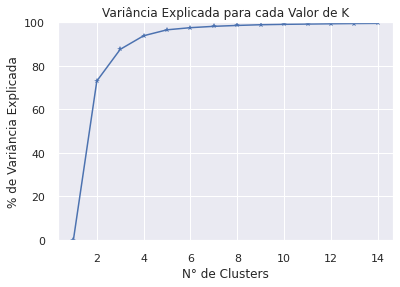

In [ ]:
# Vendo qual a quantidade ideal de clusters pelo método elbow 
dataset_atrib = df_cidades.values
k_range = range(1,15)
k_means_var = [KMeans(n_clusters = k).fit(df_cidades.values) for k in k_range]

# Ajustando o centróide do cluster para cada modelo
centroide = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(dataset_atrib, cent, 'euclidean') for cent in centroide]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(dataset_atrib)**2)/dataset_atrib.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('N° de Clusters')
plt.ylabel('% de Variância Explicada')
plt.title('Variância Explicada para cada Valor de K')

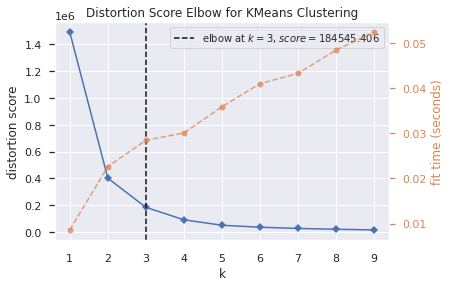

In [ ]:
# Visualizando a curva feita através da biblioteca Yellowbrick, que nos mostra o melhor score. 
kmeans = KMeans()
kmeans.fit(df_cidades)
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(df_cidades)
visualizer.show()

A curva de Elbow sugere 3 clusters para clusterizar as cidades. Vamos testar o número ideal de clusters utilizando o método Silhouette Score. 

In [ ]:
# 6 Clusters 

modelo_k5 = KMeans(n_clusters = 6, init = 'k-means++', n_init = 10, max_iter = 300)
modelo_k5.fit(dataset_atrib)
# Silhouette Score
labels = modelo_k5.labels_
silhouette_score(dataset_atrib, labels, metric = 'euclidean')

0.6797386863296769

In [ ]:
# 5 Clusters 

modelo_k5 = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 300)
modelo_k5.fit(dataset_atrib)
# Silhouette Score
labels = modelo_k5.labels_
silhouette_score(dataset_atrib, labels, metric = 'euclidean')

0.7007519330213319

In [ ]:
# 4 Clusters
 
modelo_k4 = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300)
modelo_k4.fit(dataset_atrib)
# Silhouette Score
labels = modelo_k4.labels_
silhouette_score(dataset_atrib, labels, metric = 'euclidean')

0.6884044680108619

In [ ]:
# 3 Clusters
 
modelo_k3 = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, max_iter = 300)
modelo_k3.fit(dataset_atrib)
# Silhouette Score
labels = modelo_k3.labels_
silhouette_score(dataset_atrib, labels, metric = 'euclidean')

0.6254670795756655

In [ ]:
# 2 Clusters
 
modelo_k2 = KMeans(n_clusters = 2, init = 'k-means++', n_init = 10, max_iter = 300)
modelo_k2.fit(dataset_atrib)
# Silhouette Score
labels = modelo_k2.labels_
silhouette_score(dataset_atrib, labels, metric = 'euclidean')

0.7037333168014099

O Silhouette Score sugere a quantidade de clusters igual à 5. 

### Definindo variáveis para clusterização

In [ ]:
df_cidades.columns

Index(['cidade_destino_id', 'delivery_minutes_norm', 'delay'], dtype='object')

**Adicionando variável quantidade de entregas**

Essa variável está no dataframe destinos

In [ ]:
destinos.head()

,cidade_destino_id,delay,qtd_delivery_cidade
0,1,0.266667,30
1,2,0.047538,589
2,3,0.000000,18
3,6,0.096774,31
4,7,0.000000,6


In [ ]:
destinos2 = destinos.drop('delay', axis=1)

In [ ]:
df_cidades_destinos = pd.merge(left=df_cidades, right=destinos2, on='cidade_destino_id')
df_cidades_destinos

,cidade_destino_id,delivery_minutes_norm,delay,qtd_delivery_cidade
0,25,0.799618,0,85
1,25,-0.720036,0,85
2,25,-0.687677,0,85
3,25,1.142557,0,85
4,25,0.328872,0,85
...,...,...,...,...
1790,98,1.901814,1,2
1791,95,1.301007,1,1
1792,124,1.288095,1,1
1793,115,1.579069,0,1


In [ ]:
# normalizando "qtd_delivery_cidade" 
df_cidades_destinos['qtd_delivery_norm'] = Scaler.fit_transform(df_cidades_destinos['qtd_delivery_cidade'].values.reshape(-1,1))

In [ ]:
df_cidades.columns

Index(['cidade_destino_id', 'delivery_minutes_norm', 'delay'], dtype='object')

In [ ]:
# Ultima chance de mudar variáveis na clusterização
df_cidades2 = df_cidades[['cidade_destino_id', 'delivery_minutes_norm', 'delay']]
df_cidades2['qtd_delivery_norm'] = df_cidades_destinos['qtd_delivery_norm']

df_cidades2.columns

Index(['cidade_destino_id', 'delivery_minutes_norm', 'delay',
       'qtd_delivery_norm'],
      dtype='object')

## Clusterização das cidades

In [ ]:
# Clusterizando  

# Gaussian Mixture 
model_clustering = GaussianMixture(n_components=5, max_iter=500, random_state=42)
ypred_gauss = model_clustering.fit_predict(df_cidades2)

# KMeans
model_clustering_K = KMeans(n_clusters = 5)
ypred_kmeans = model_clustering_K.fit_predict(df_cidades2)

#KMeans++ 
model_plusplus = KMeans(5, random_state = 42, init='k-means++')
ypred_kmeansplusplus = model_plusplus.fit_predict(df_cidades2)

# Kmethoids 
model_medoids = KMedoids(n_clusters=5, random_state=42, metric='euclidean',init='k-medoids++') 
ypred_medoids = model_medoids.fit_predict(df_cidades2)

# MeanShift
ypred_ms = MeanShift(bandwidth=5).fit_predict(df_cidades2)

# Fuzzy K-means
fcm = FCM(n_clusters=10,random_state = 42,init='k-means++')
fcm.fit(np.array(df_cidades2))
ypred_fcm = fcm.predict(np.array(df_cidades2))

# DBSCAN
db = DBSCAN(eps=0.75)
ypred_db = db.fit_predict(df_cidades2)

## Escolha do algoritmo de clusterização

Após vários testes, optou-se pela clusterização das cidades via algoritmo DBSCAN com hiperparâmetro eps de 0.75.  

In [ ]:
# CRIANDO DUMMYS DOS CLUSTERS 

cluster_escolhido = ypred_db.copy()
df_final_clusters = pd.get_dummies(cluster_escolhido, prefix='cluster', drop_first=True)
#display(df_final_clusters.head(3))
print('Quantidade de clusters:', df_final_clusters.columns.shape[0]+1)

Quantidade de clusters: 75


## Preparando dataframe final

**Adicionando dummies de clusters no dataframe**

In [ ]:
df_dados = pd.merge(left=df_final3, right=df_final_clusters, left_index=True, right_index=True)
df_dados.head(2)

,id,order_date,due_date,opt_date,delivery_date,cidade_origem_id,cidade_destino_id,delay,final_semana,regiao_destino_2,...,cluster_64,cluster_65,cluster_66,cluster_67,cluster_68,cluster_69,cluster_70,cluster_71,cluster_72,cluster_73
0,0,2022-02-25 20:46:25,2022-03-02 23:59:59,2022-02-28 20:35:20,2022-03-02 18:03:33,2,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2022-02-23 20:34:59,2022-02-24 23:59:59,2022-02-24 09:56:23,2022-02-24 15:52:40,2,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_dados.columns

Index(['id', 'order_date', 'due_date', 'opt_date', 'delivery_date',
       'cidade_origem_id', 'cidade_destino_id', 'delay', 'final_semana',
       'regiao_destino_2', 'regiao_destino_4', 'regiao_origem_2',
       'regiao_origem_3', 'peso_norm', 'price_norm', 'delivery_minutes_norm',
       'complexidade_minutes', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
       'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12',
       'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
       'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22',
       'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27',
       'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32',
       'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36', 'cluster_37',
       'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41', 'cluster_42',
       'cluster_43', 'cluster_44', '

In [ ]:
# Gerando df_final : apagando as colunas que não vão ser usadas no modelo de df_dados 

df_final = df_dados.drop(columns=['id', 'order_date', 'due_date', 'opt_date', 'delivery_date', 'cidade_origem_id', 'cidade_destino_id'])

Também tinha sido adicionada a quantidade de entregas normalizada no df_final, mas uma análise posterior revelou que essa feature estava sujeita a multicolinearidade com outras features do modelo. Portanto, foi optado por retirá-la do modelo. 

## Modelagem

### Separação dos dados entre treino e teste e execução dos algoritmos de classificação

**Criando um modelo pra prever se uma entrega vai atrasar ou não**


In [ ]:
X = df_final[df_final.columns[~df_final.columns.isin(['delay', 'regiao_destino_4'])]]
y = df_final['delay']

A variável regiao_destino_4 obteve um VIF considerável na análise de multicolinearidade realizada posteriormente. Dessa forma, optou-se por removê-la.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1436, 82), (359, 82), (1436,), (359,))

In [ ]:
classification_models = {"LogisticRegression": LogisticRegression(random_state=42),
                         "DecisionTree":DecisionTreeClassifier(random_state=42),
                         "RandomForest": RandomForestClassifier(random_state=42),
                         "XGBoost": XGBClassifier(random_state=42),
}

In [ ]:
# Criando um looping para testar todos os modelos 

df_results = pd.DataFrame(columns=['model', 'run_time', 'recall', 'f1_score','accuracy'])

for key in classification_models:

    print('*',key)

    start_time = time.time()

    clas = classification_models[key]
    model = clas.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)

    scores = cross_val_score(model,
                             Xtrain,
                             ytrain,
                             scoring='f1',
                             cv=5)
    
    print('scores: ', scores)
    print('média scores: ', np.mean(scores))
    print()

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'recall': recall_score(ytest, y_pred),
           'f1_score': f1_score(ytest, y_pred),
           'accuracy': accuracy_score(ytest, y_pred),
           'precision': precision_score(ytest, y_pred)
    }

    df_results = df_results.append(row, ignore_index=True)

* LogisticRegression
scores:  [0.92307692 0.95       0.95       0.89473684 0.97560976]
média scores:  0.9386847042559495

* DecisionTree
scores:  [0.96551724 0.91764706 0.93975904 0.90909091 0.94252874]
média scores:  0.9349085962141022

* RandomForest
scores:  [0.8974359  0.95121951 0.925      0.9        0.90243902]
média scores:  0.9152188868042528

* XGBoost
scores:  [0.97560976 0.94117647 0.925      0.93670886 0.94117647]
média scores:  0.943934311606705



### Resultados

In [ ]:
df_results

,model,run_time,recall,f1_score,accuracy,precision
0,LogisticRegression,0.0,0.765957,0.867470,0.969359,1.000000
1,DecisionTree,0.0,0.829787,0.857143,0.963788,0.886364
2,RandomForest,0.03,0.787234,0.860465,0.966574,0.948718
3,XGBoost,0.03,0.872340,0.921348,0.980501,0.976190


Foram testadas várias combinações de modelos, tanto para clusterização das cidades quanto de classificação, com diversos hiperparâmetros. O modelo que apresentou o melhor resultado nas métricas (em especial, f1_score) na grande maioria das vezes foi o Random Forest. Dessa forma, optou-se pela escolha do mesmo para a otimização de hiperparâmetros. 

### Análise de multicolinearidade com VIF - Variance Inflation Factor

In [ ]:
# criando dataframe com os dados utilizados na modelagem de X e y 
df_x = df_final[df_final.columns[~df_final.columns.isin(['delay', 'regiao_destino_4'])]]
df_y = df_final['delay']

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_x.columns
  
# Calculando o VIF para cada feature
vif_data["VIF"] = [variance_inflation_factor(df_x.values, i)
                          for i in range(len(df_x.columns))]
  
print(vif_data.sort_values(by='VIF',ascending=False))

                  feature       VIF
2         regiao_origem_2  2.853014
7    complexidade_minutes  2.540595
6   delivery_minutes_norm  2.251924
3         regiao_origem_3  2.211853
1        regiao_destino_2  1.934438
..                    ...       ...
52             cluster_44  1.004868
34             cluster_26  1.004309
26             cluster_18  1.003866
38             cluster_30  1.002111
47             cluster_39  1.001188

[82 rows x 2 columns]


O modelo obteve valores aceitáveis de VIF. Portanto, aparentemente não apresenta alta multicolinearidade entre as variáveis. 

### Otimização de hiperparâmetros via GridSearchCV

>1, train: 0.000, test: 0.869
>2, train: 0.000, test: 0.869
>3, train: 0.150, test: 0.872
>4, train: 0.264, test: 0.872
>5, train: 0.385, test: 0.894
>6, train: 0.614, test: 0.905
>7, train: 0.645, test: 0.911
>8, train: 0.754, test: 0.928
>9, train: 0.824, test: 0.939
>10, train: 0.833, test: 0.939
>11, train: 0.886, test: 0.939
>12, train: 0.918, test: 0.947
>13, train: 0.915, test: 0.942
>14, train: 0.915, test: 0.950
>15, train: 0.923, test: 0.944
>16, train: 0.929, test: 0.953
>17, train: 0.945, test: 0.953
>18, train: 0.939, test: 0.961
>19, train: 0.953, test: 0.961
>20, train: 0.958, test: 0.967
>21, train: 0.971, test: 0.967
>22, train: 0.990, test: 0.967
>23, train: 0.993, test: 0.961
>24, train: 0.993, test: 0.967
>25, train: 0.998, test: 0.964
>26, train: 0.998, test: 0.964
>27, train: 1.000, test: 0.967
>28, train: 1.000, test: 0.972
>29, train: 1.000, test: 0.964


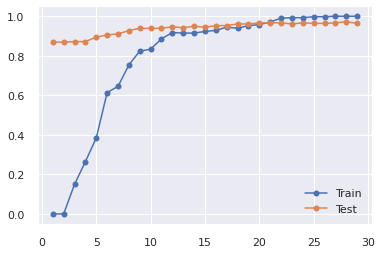

In [ ]:
# Obtendo os melhores valores de max_depth para o GridSearchCV do Random Forest. 

train_scores, test_scores = list(), list()
values = [i for i in range(1, 30)]
for i in values:
	model_depth = RandomForestClassifier(max_depth=i)
	model_depth.fit(Xtrain, ytrain)
	train_yhat = model_depth.predict(Xtrain)
	train_f1 = f1_score(ytrain, train_yhat)
	train_scores.append(train_f1)
	test_yhat = model_depth.predict(Xtest)
	test_f1 = accuracy_score(ytest, test_yhat)
	test_scores.append(test_f1)
	print('>%d, train: %.3f, test: %.3f' % (i, train_f1, test_f1))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Percebe-se que o dataset de treino começa a performar melhor que o de teste a partir do max depth 21. Dessa forma, optou-se por usar esse hiperparâmetro entre 17-20 no GridSearchCV. 

In [ ]:
# GridSearchCV

model = RandomForestClassifier()

parameters = {"n_estimators" : [100, 200, 500, 1000, 2000],
"criterion" : ["gini", "entropy", "log_loss"],
"max_depth" : [17, 18, 19, 20],
"max_features" : ["sqrt", "log2", "None"],
}

grid_search = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=5, scoring='f1')
grid_result = grid_search.fit(Xtrain, ytrain)

In [ ]:
print('Best Score: %s' % grid_result.best_score_)
print('Best Hyperparameters: %s' % grid_result.best_params_)

Best Score: 0.9094686552513043
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 2000}


In [ ]:
# Rodando o Random Forest Otimizado

model_grid = RandomForestClassifier(criterion = 'entropy', max_depth = 20, max_features = 'sqrt', n_estimators = 2000, n_jobs = -1).fit(Xtrain, ytrain)
ypred_grid = model_grid.predict(Xtest) 

In [ ]:
print('Quantidade de previsões: ', ypred_grid.shape[0])
print('Quantidade de entregas previstas como atraso: ', len(ypred_grid[ypred_grid==1]))
print('Porcentagem de entregas previstas como atraso pelo modelo: {:.2f}%'.format(((len(ypred_grid[ypred_grid==1]))/ypred_grid.shape[0])*100))
print('Porcentagem de entregas atrasadas do dataset total: {:.2f}%'.format((df_final[df_final['delay']==1].shape[0]/df_final.shape[0])*100))

Quantidade de previsões:  359
Quantidade de entregas previstas como atraso:  35
Porcentagem de entregas previstas como atraso pelo modelo: 9.75%
Porcentagem de entregas atrasadas do dataset total: 14.32%


In [ ]:
acc_grid = accuracy_score(ytest, ypred_grid)
f1_grid = f1_score(ytest, ypred_grid)
recall_grid = recall_score(ytest, ypred_grid)
precision_grid = precision_score(ytest, ypred_grid)

In [ ]:
print('Accuracy - Random Forest otimizado via GridSearchCV: {:.2f}%'.format(acc_grid*100))
print('F1 Score - Random Forest otimizado via GridSearchCV: {:.2f}%'.format(f1_grid*100))
print('Recall - Random Forest otimizado via com GridSearchCV: {:.2f}%'.format(recall_grid*100))
print('Precision - Random Forest otimizado via com GridSearchCV: {:.2f}%'.format(precision_grid*100))

Accuracy - Random Forest otimizado via GridSearchCV: 96.10%
F1 Score - Random Forest otimizado via GridSearchCV: 82.93%
Recall - Random Forest otimizado via com GridSearchCV: 72.34%
Precision - Random Forest otimizado via com GridSearchCV: 97.14%


**Comentário sobre as métricas:** 

* A accuracy simplesmente calcula a quantidade de previsões certas divido pela quantidade de previsões feitas; como temos um dataset desbalanceado, essa métrica não é a mais indicada para avaliar a performance do modelo.  

* A precision indica que, entre todas as previsões de entregas atrasadas que o modelo fez, 97,14% dessas previsões foram corretas.

* O recall indica que, entre todas as entregas que atrasaram no dataset de teste, o modelo conseguiu prever corretamente 72,34% delas.

* Existe um trade-off entre precision e recall. Dessa forma, uma métrica interessante para se observar é o f1-score, que é uma média harmônica entre as duas. No caso, o f1-score foi a escolhida como métrica para ser otimizada no GridSearchCV.

## Conclusão

**O modelo de previsão de atraso de entregas escolhido foi um Random Forest com hiperparâmetros otimizados via GridSearchCV. Esse modelo obteve um f1_score de 82,93% nos dados de teste.**    